In [2]:
import os
import json
import time
import random
import ipinfo
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import ListedColormap

from seleniumwire import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

sns.set_palette('colorblind')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [3]:
def get_location_from_ip(access_token, ip_address):
    ipinfo_handler = ipinfo.getHandler(access_token)
    ip_address = ip_address.strip()
    details = ipinfo_handler.getDetails(ip_address)
    region = details.all['region']
    country = details.all['country']
    return region, country


def create_selenium_driver(proxy_dict):
    selenium_options = proxy_dict
    chrome_options = Options()
    chrome_options.add_argument("--no-sandbox")
    # chrome_options.add_argument("--headless")

    driver = webdriver.Chrome(
        seleniumwire_options=selenium_options, 
        options=chrome_options              
    )
    wait = WebDriverWait(driver, random.randint(7, 10))

    return driver, wait


def decline_optional_cookies(wait):
    try:
        decline_btn = wait.until(
            EC.element_to_be_clickable(
                (By.XPATH, "//button[normalize-space()='Decline optional cookies']")
            )
        )
        decline_btn.click()
    except Exception:
        # pass
        print("No 'Decline optional cookies' button found or it was not clickable.")


def close_login_popup(wait):
    try:
        close_div = wait.until(
            EC.element_to_be_clickable(
                (By.CSS_SELECTOR, "svg[aria-label='Close']")
                
            )
        )
        close_div.click()
    except Exception:
        # pass
        print("No login popup found or it was not clickable.")

### Check Proxy Locations

In [4]:
proxies_path = '/Users/brahmaninutakki/saarland/docs/proxies/2024-05-27 06 53 59.txt'

with open(proxies_path, 'r') as f:
    proxies = f.readlines()

ips = [proxy.split(':')[0] for proxy in proxies]

In [5]:
ips[:5]

['31.131.11.187',
 '172.81.23.200',
 '107.166.116.67',
 '31.131.9.22',
 '172.81.21.41']

In [6]:
# get ip inferred locations
ip_locations = {}
for ip in tqdm(ips):
    region, country = get_location_from_ip('73b7dc7b513e06', ip)
    ip_locations[ip] = {'region': region, 'country': country}

100%|██████████| 111/111 [00:22<00:00,  4.83it/s]


In [7]:
ip_locations

{'31.131.11.187': {'region': 'Virginia', 'country': 'US'},
 '172.81.23.200': {'region': 'New York', 'country': 'US'},
 '107.166.116.67': {'region': 'New York', 'country': 'US'},
 '31.131.9.22': {'region': 'Virginia', 'country': 'US'},
 '172.81.21.41': {'region': 'New York', 'country': 'US'},
 '172.81.20.69': {'region': 'New York', 'country': 'US'},
 '162.218.13.126': {'region': 'Texas', 'country': 'US'},
 '52.128.216.28': {'region': 'New York', 'country': 'US'},
 '31.131.8.161': {'region': 'Virginia', 'country': 'US'},
 '23.226.24.128': {'region': 'New Jersey', 'country': 'US'},
 '172.81.22.204': {'region': 'New York', 'country': 'US'},
 '31.131.10.143': {'region': 'Virginia', 'country': 'US'},
 '31.131.11.55': {'region': 'Virginia', 'country': 'US'},
 '172.81.23.163': {'region': 'New York', 'country': 'US'},
 '107.166.116.224': {'region': 'New York', 'country': 'US'},
 '31.131.9.147': {'region': 'Virginia', 'country': 'US'},
 '172.81.21.77': {'region': 'New York', 'country': 'US'},
 '

In [8]:
unique_cities = set()
for ip, loc in ip_locations.items():
    unique_cities.add(loc['region'])

unique_cities

{'Lower Saxony', 'New Jersey', 'New York', 'Texas', 'Virginia'}

### Setup crawls

In [9]:
msnbc_urls = [
    "https://www.instagram.com/msnbc/reel/DQz6GiKkqD-/",
    "https://www.instagram.com/msnbc/reel/DQzvigyiu3R/",
    "https://www.instagram.com/msnbc/reel/DQzaxBeisq2/",
    "https://www.instagram.com/msnbc/reel/DQzOhJyil7B/",
    "https://www.instagram.com/msnbc/reel/DQx_MsXDdqz/",
    "https://www.instagram.com/reel/DQx6d6TDFvD/",
    "https://www.instagram.com/reel/DQxz17nkXAu/",
    "https://www.instagram.com/reel/DQxxwsjEQxy/",
    "https://www.instagram.com/reel/DQxf5uvERD0/",
    "https://www.instagram.com/reel/DQxc21kkqwR/",
]

huffpost_urls = [
    "https://www.instagram.com/huffpost/reel/DQzSuMQARR0/",
    "https://www.instagram.com/huffpost/p/DQxLW-PEns-/",
    "https://www.instagram.com/huffpost/reel/DQxARFuAbt-/",
    "https://www.instagram.com/huffpost/reel/DQw6Qa_kWgY/",
    "https://www.instagram.com/huffpost/reel/DQw5_xHkWod/",
    "https://www.instagram.com/huffpost/reel/DQwbCxQjQNQ/",
    "https://www.instagram.com/huffpost/p/DQu2w59E9t-/",
    "https://www.instagram.com/huffpost/reel/DQvEm2FDCmz/",
    "https://www.instagram.com/huffpost/p/DQuw7U7D322/",
    "https://www.instagram.com/p/DQujjUrk61E/"
]

cnn_urls = [
    "https://www.instagram.com/reel/DQ0VgDjjx7K/",
    "https://www.instagram.com/p/DQ0LWj6jue3/",
    "https://www.instagram.com/reel/DQz7vqJiEUj/",
    "https://www.instagram.com/reel/DQznNr7gp1F/",
    "https://www.instagram.com/reel/DQzgXgPgPmN/",
    "https://www.instagram.com/reel/DQzNYM8ARN3/",
    "https://www.instagram.com/reel/DQzEp0pChCY/",
    "https://www.instagram.com/reel/DQy-AdiCcH_/",
    "https://www.instagram.com/reel/DQyzpQVjga4/",
    "https://www.instagram.com/reel/DQypWvmDoge/"
]

washingtonpost_urls = [
    "https://www.instagram.com/washingtonpost/p/DQ0JgL9DqcC/",
    "https://www.instagram.com/washingtonpost/p/DQz7wRODMr8/",
    "https://www.instagram.com/washingtonpost/p/DQzuD3fFJcu/",
    "https://www.instagram.com/washingtonpost/reel/DQzh-t0DSAJ/",
    "https://www.instagram.com/washingtonpost/reel/DQzgTDHAcKl/",
    "https://www.instagram.com/p/DQzZihPDiQv/",
    "https://www.instagram.com/reel/DQzSo12D1fJ/",
    "https://www.instagram.com/reel/DQzLtq3ARq3/",
    "https://www.instagram.com/p/DQxxk6BDvZh/",
    "https://www.instagram.com/p/DQxqaCpDcHC/"
]

forbes_urls = [
    "https://www.instagram.com/forbes/p/DQ0Ck-lgUxt/",
    "https://www.instagram.com/forbes/p/DQz0444AWAd/",
    "https://www.instagram.com/forbes/p/DQzgP9_gcjC/",
    "https://www.instagram.com/p/DQzUOiGAblX/",
    "https://www.instagram.com/p/DQzLpqJDxMD/",
    "https://www.instagram.com/p/DQzFWzxkT-c/",
    "https://www.instagram.com/p/DQxdypCDPF2/",
    "https://www.instagram.com/p/DQxOpmbkn_b/",
    "https://www.instagram.com/p/DQxFjBJj4gS/",
    "https://www.instagram.com/p/DQxElAzD6aK/"
]

thehill_urls = [
    "https://www.instagram.com/thehill/p/DQzfVDcE3YB/",
    "https://www.instagram.com/thehill/p/DQxg1ufkeqR/",
    "https://www.instagram.com/thehill/reel/DQxViLFEdQ5/",
    "https://www.instagram.com/thehill/p/DQw1LZxEwrn/",
    "https://www.instagram.com/thehill/p/DQwgkZxD2Ug/",
    "https://www.instagram.com/thehill/reel/DQvAK9hEeWU/",
    "https://www.instagram.com/thehill/p/DQunQLokn-7/",
    "https://www.instagram.com/thehill/reel/DQuNa5zEeiR/",
    "https://www.instagram.com/thehill/p/DQt9lxsjumG/",
    "https://www.instagram.com/reel/DQrpC35EXqn/"
]

washingtontimes_urls = [
    "https://www.instagram.com/washtimes/p/DQz0CxJExjr/",
    "https://www.instagram.com/washtimes/p/DQzcWsGkg8C/",
    "https://www.instagram.com/washtimes/p/DQxHICQE_29/",
    "https://www.instagram.com/washtimes/p/DQw_V8sE6ZH/",
    "https://www.instagram.com/washtimes/p/DQw3jz6k0L6/",
    "https://www.instagram.com/washtimes/p/DQwvq-dktiv/",
    "https://www.instagram.com/washtimes/p/DQwn4b2EzCR/",
    "https://www.instagram.com/washtimes/p/DQwgGZ2jQck/",
    "https://www.instagram.com/washtimes/p/DQvCB1iEwBa/",
    "https://www.instagram.com/washtimes/reel/DQu5zA1CL3U/"
]

nypost_urls = [
    "https://www.instagram.com/p/DQ0Jd_SAc4Z/",
    "https://www.instagram.com/p/DQ0GBAngWyx/",
    "https://www.instagram.com/reel/DQ0ETkoDtLN/",
    "https://www.instagram.com/p/DQ0ClEugU1r/",
    "https://www.instagram.com/p/DQz_JRkAWr9/",
    "https://www.instagram.com/reel/DQz9kQIDZOc/",
    "https://www.instagram.com/p/DQz70tPAQTn/",
    "https://www.instagram.com/p/DQz4Y1Xgadc/",
    "https://www.instagram.com/reel/DQz2rWGEkpe/",
    "https://www.instagram.com/p/DQz09vagSe1/"
]

foxnews_urls = [
    "https://www.instagram.com/reel/DQ0V_qAEfwE/",
    "https://www.instagram.com/reel/DQ0UdiODE-2/",
    "https://www.instagram.com/reel/DQ0UNIZD3rv/",
    "https://www.instagram.com/reel/DQ0OfgWAswZ/",
    "https://www.instagram.com/reel/DQ0OAwCk91U/",
    "https://www.instagram.com/reel/DQ0GaXEjofE/",
    "https://www.instagram.com/reel/DQ0ClztkmYz/",
    "https://www.instagram.com/p/DQ0AYUTkvh4/",
    "https://www.instagram.com/p/DQz8ZTUjJ4s/",
    "https://www.instagram.com/reel/DQz8UW2j4TQ/"
]

breitbart_urls = [
    "https://www.instagram.com/p/DQ0P_UtDFLj/",
    "https://www.instagram.com/p/DQ0ImR1DaM0/",
    "https://www.instagram.com/p/DQz28XJkuQV/",
    "https://www.instagram.com/p/DQzkN12CUZQ/",
    "https://www.instagram.com/reel/DQzXuPOkgOo/",
    "https://www.instagram.com/p/DQzR5CjkQxS/",
    "https://www.instagram.com/p/DQzJCenDSPC/",
    "https://www.instagram.com/p/DQy1VfcETEi/",
    "https://www.instagram.com/reel/DQxZ3LCkvgh/",
    "https://www.instagram.com/p/DQxfi8JjVGb/"
]

all_urls = {
    'msnbc': msnbc_urls,
    'huffpost': huffpost_urls,
    'cnn': cnn_urls,
    'washingtonpost': washingtonpost_urls,
    'forbes': forbes_urls,
    'thehill': thehill_urls,
    'washingtontimes': washingtontimes_urls,
    'nypost': nypost_urls,
    'foxnews': foxnews_urls,
    'breitbart': breitbart_urls
}

#### no user baselines

In [ ]:
proxy_map = {'172.81.22.22': 'ny_1',
             '172.81.21.149': 'ny_2',
             '162.218.13.134': 'texas_1',
             '162.218.13.80': 'texas_2'} 

proxy = '162.218.13.80'
proxy_dict = {'https': f'http://iweber02:qp9dQbDM@{proxy}:29842'}

for name, urls in tqdm(all_urls.items()): 

    save_path = f'/Users/brahmaninutakki/saarland/insta-comments/saved_data/{proxy_map[proxy]}/{name}'

    if not os.path.exists(save_path):
        os.makedirs(save_path)


    driver, wait = create_selenium_driver(proxy_dict)

    for url in urls:
        url_id = url.split('/')[-2]

        if os.path.exists(f'{save_path}/{url_id}_comments.json'):
            print(f"Skipping...")
            continue

        else:
            driver.get(url)
            decline_optional_cookies(wait)
            close_login_popup(wait)

            try:
                classes = "x1lliihq x1plvlek xryxfnj x1n2onr6 xyejjpt x15dsfln x193iq5w xeuugli x1fj9vlw x13faqbe x1vvkbs x1s928wv xhkezso x1gmr53x x1cpjm7i x1fgarty x1943h6x x1i0vuye xvs91rp xo1l8bm x5n08af x10wh9bi xpm28yp x8viiok x1o7cslx"
                selector = "span." + ".".join(classes.split())
                content = wait.until(
                    EC.presence_of_all_elements_located((By.CSS_SELECTOR, selector))
                )

                content = [comment.text for comment in content]

                
                with open(f'{save_path}/{url_id}_comments.json', 'w') as f:
                    json.dump(content, f)
            except Exception as e:
                print(f"Error extracting comments for {name}:{url}", e)

            time.sleep(random.randint(2, 5))

    driver.close()

    time.sleep(random.randint(5, 10))


#### Persona Crawls 

In [14]:
ip_locations['162.218.13.80']

{'region': 'Texas', 'country': 'US'}

In [63]:
proxy_map = {'172.81.22.22': 'ny_1',
             '172.81.21.149': 'ny_2',
             '162.218.13.134': 'texas_1',
             '162.218.13.80': 'texas_2',
             '31.131.10.208': 'blub'} 

proxy = '162.218.13.80'
url = all_urls['msnbc'][6]
# url = 'https://www.instagram.com/accounts/login/'
# proxy_dict = {'https': f'http://iweber02:qp9dQbDM@{proxy}:29842'}

# male dem
# uname = 'bjsdbfajajba'
# pwd = 'bjsdbfajajba2000'
# female rep
# uname = 'jabfjadbajb'
# pwd = 'D$O2fQ!lCe9X9Q'
# male rep
uname = 'bhbjkndjsna'
pwd = 'fepvox-sewGyt-3ryrxi'
# female dem
# uname = 'sdbhjsajbdja '
# pwd = '_5Kn*H]8qpT3$7&'

dir_name = 'male_rep'

driver, wait = create_selenium_driver(proxy_dict)
driver.get(url)
decline_optional_cookies(wait)

time.sleep(random.randint(2, 3))
try:
    login_btn = wait.until(
        EC.element_to_be_clickable(
            (By.XPATH, "//div[@role='button' and normalize-space()='Log In']")
        )
    )
    login_btn.click()
except Exception:
    print("No 'Log In' button found or it was not clickable.")

try:
    login_btn = wait.until(
        EC.element_to_be_clickable(
            (By.XPATH, "/html/body/div[1]/div/div/div[2]/div/div/div[1]/div[1]/div[1]/section/main/div[1]/div[2]/div/div/div/div/div[2]/div/div[2]/div[2]/div/a")
        )
    )
    login_btn.click()
except Exception:
    print("No 'Log In' button found or it was not clickable.")

try:
    login_btn = wait.until(
        EC.element_to_be_clickable(
            (By.XPATH, "/html/body/div[1]/div/div/div[2]/div/div/div[1]/div[1]/div[1]/section/div/div/div[2]/div/div/div/div[1]/a]")
        )
    )
    login_btn.click()
except Exception:
    print("No 'Log In' button found or it was not clickable.")


time.sleep(random.randint(2, 5))
try:
    username = wait.until(EC.element_to_be_clickable(
        (By.CSS_SELECTOR, 'input[aria-label="Phone number, username or email address"]')
    ))
    username.clear()
    username.send_keys(uname)
except Exception as e:
    print("username error", e)

try:
    password = wait.until(EC.element_to_be_clickable(
        (By.CSS_SELECTOR, 'input[aria-label="Password"]')
    ))
    password.clear()
    password.send_keys(pwd)
except Exception:
    print("pwd error")

time.sleep(random.randint(2, 5))
try:
    login_btn = wait.until(
        EC.element_to_be_clickable(
            (By.XPATH, "//button[@type='submit' and .//div[normalize-space()='Log in'] and not(@disabled)]")
        )
    )
    login_btn.click()
except Exception:
    print("No 'Log In' button found or it was not clickable.")

time.sleep(random.randint(2, 5))
try:
    username = wait.until(EC.element_to_be_clickable(
        (By.CSS_SELECTOR, 'input[aria-label="Phone number, username or email address"]')
    ))
    username.clear()
    username.send_keys(uname)
except Exception as e:
    print("username error", e)

try:
    password = wait.until(EC.element_to_be_clickable(
        (By.CSS_SELECTOR, 'input[aria-label="Password"]')
    ))
    password.clear()
    password.send_keys(pwd)
except Exception:
    print("pwd error")

time.sleep(random.randint(2, 5))
try:
    login_btn = wait.until(
        EC.element_to_be_clickable(
            (By.XPATH, "//button[@type='submit' and .//div[normalize-space()='Log in'] and not(@disabled)]")
        )
    )
    login_btn.click()
except Exception:
    print("No 'Log In' button found or it was not clickable.")


decline_optional_cookies(wait)

time.sleep(random.randint(2, 5))
try:
    dont_save = wait.until(
        EC.element_to_be_clickable(
            (By.XPATH, "//div[@role='button' and normalize-space()='Not now']")
        )
    )
    dont_save.click()
except Exception:
    print("No 'Not now' button found or it was not clickable.")

decline_optional_cookies(wait)

time.sleep(random.randint(15, 25))

for name, urls in tqdm(all_urls.items()):
    for url in urls:
        url_id = url.split('/')[-2]
        save_path = f'/Users/brahmaninutakki/saarland/insta-comments/saved_data/{dir_name}/{proxy_map[proxy]}/{name}'


        if os.path.exists(f'{save_path}/{url_id}_comments.json'):
            print(f"Skipping...")
            continue

        driver.switch_to.new_window('tab')
        driver.get(url)
        decline_optional_cookies(wait)
        try:
            login_btn = wait.until(
                EC.element_to_be_clickable(
                    (By.XPATH, "//div[@role='button' and normalize-space()='Log In']")
                )
            )
            login_btn.click()
        except Exception:
            print("No 'Log In' button found or it was not clickable.")

        try:
            classes = "x1lliihq x1plvlek xryxfnj x1n2onr6 xyejjpt x15dsfln x193iq5w xeuugli x1fj9vlw x13faqbe x1vvkbs x1s928wv xhkezso x1gmr53x x1cpjm7i x1fgarty x1943h6x x1i0vuye xvs91rp xo1l8bm x5n08af x10wh9bi xpm28yp x8viiok x1o7cslx"
            selector = "span." + ".".join(classes.split())
            content = wait.until(
                EC.presence_of_all_elements_located((By.CSS_SELECTOR, selector))
            )

            content = [comment.text for comment in content]

            if not os.path.exists(save_path):
                os.makedirs(save_path)
            
            with open(f'{save_path}/{url_id}_comments.json', 'w') as f:
                json.dump(content, f)
        except Exception as e:
            print(f"Error extracting comments for {name}:{url}", e)

        driver.close()

        if driver.window_handles:
            driver.switch_to.window(driver.window_handles[0])

        time.sleep(random.randint(2, 5))

    time.sleep(random.randint(10, 15))

driver.quit()

No 'Log In' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.


  0%|          | 0/10 [00:00<?, ?it/s]

No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not

 10%|█         | 1/10 [03:46<34:01, 226.88s/it]

No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not

 20%|██        | 2/10 [07:27<29:46, 223.26s/it]

No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not

 30%|███       | 3/10 [11:16<26:22, 226.02s/it]

No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not

 40%|████      | 4/10 [15:04<22:40, 226.79s/it]

No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not

 50%|█████     | 5/10 [18:40<18:34, 222.91s/it]

No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not

 60%|██████    | 6/10 [22:26<14:54, 223.70s/it]

No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not

 70%|███████   | 7/10 [25:54<10:55, 218.65s/it]

No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not

 80%|████████  | 8/10 [29:33<07:17, 218.72s/it]

No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not

 90%|█████████ | 9/10 [33:27<03:43, 223.48s/it]

No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not clickable.
No 'Log In' button found or it was not clickable.
No 'Decline optional cookies' button found or it was not

100%|██████████| 10/10 [37:16<00:00, 223.67s/it]


In [61]:
driver.quit()

### Convert into df

In [7]:
crawls = ['ny_1', 'ny_2', 'texas_1', 'texas_2', 'male_dem_ny_1_100925', 'male_dem_ny_1', 'female_rep_ny_1', 'male_dem_texas_1', 'female_rep_texas_1']
dfs = []

for crawl in crawls:

    df = pd.DataFrame(columns=['file_name', 'account_name', 'url_id', 'comment_num', f'{crawl}_comments'])
    temp_list = []

    for account_name in all_urls.keys():
        files = os.listdir(f'/Users/brahmaninutakki/saarland/insta-comments/saved_data/{crawl}/{account_name}/')
        for file in files:
            with open(f'/Users/brahmaninutakki/saarland/insta-comments/saved_data/{crawl}/{account_name}/{file}', 'r') as f:
                comments = json.load(f)

            captions = comments[0]

            if len(comments) > 2:
                user_comment_map = {}
                for index, val in enumerate(comments):
                    if index == 0:
                        continue

                    if val in user_comment_map.values():
                        continue
                    
                    user_comment_map[val] = comments[index + 1]

                    if comments[index + 1] == comments[-2]:
                        break

                if 'likes' in comments[-1].lower():
                    likes = comments[-1]

                for idx, comment in enumerate(user_comment_map.items()):

                    temp = {'file_name': file,
                            'account_name': account_name,
                            'url_id': file.split('_comments')[0],
                            'caption': captions,
                            'likes': likes,
                            'comment_num': idx,
                            f'{crawl}_comments': comment}
                    temp_list.append(temp)
            else:
                temp = {'file_name': file,
                        'account_name': account_name,
                        'url_id': file.split('_comments')[0],
                        'caption': captions,
                        'likes': None,
                        'comment_num': 0,
                        f'{crawl}_comments': None}
                temp_list.append(temp)
            

    df = pd.DataFrame(temp_list)
    dfs.append(df)

In [8]:
for df in dfs:
    print(df.shape)

(1196, 7)
(1180, 7)
(1123, 7)
(1179, 7)
(1120, 7)
(1049, 7)
(1099, 7)
(1103, 7)
(1100, 7)


In [9]:
for df in dfs:
    df.drop(columns=['caption', 'likes', 'account_name', 'url_id'], inplace=True)

In [10]:
merged_df = dfs[0]
for df in dfs[1:]:
    merged_df = pd.merge(merged_df, df, on=['file_name', 'comment_num'], how='outer')

merged_df.shape

(1239, 11)

In [11]:
merged_df.duplicated().sum()
merged_df.drop_duplicates(inplace=True)

In [12]:
merged_df.columns

Index(['file_name', 'comment_num', 'ny_1_comments', 'ny_2_comments', 'texas_1_comments', 'texas_2_comments', 'male_dem_ny_1_100925_comments', 'male_dem_ny_1_comments', 'female_rep_ny_1_comments', 'male_dem_texas_1_comments', 'female_rep_texas_1_comments'], dtype='object')

In [13]:
merged_df[['ny_1_comments', 'ny_2_comments', 'texas_1_comments', 'texas_2_comments', 'male_dem_ny_1_100925_comments', 'male_dem_ny_1_comments', 'female_rep_ny_1_comments']].isna().sum()

ny_1_comments                     45
ny_2_comments                     45
texas_1_comments                 102
texas_2_comments                  46
male_dem_ny_1_100925_comments    106
male_dem_ny_1_comments           175
female_rep_ny_1_comments         125
dtype: int64

In [122]:
merged_df.head()

,file_name,comment_num,ny_1_comments,ny_2_comments,texas_1_comments,texas_2_comments,male_dem_ny_1_100925_comments,male_dem_ny_1_comments,female_rep_ny_1_comments,male_dem_texas_1_comments,female_rep_texas_1_comments
0,DQ0AYUTkvh4_comments.json,0,"(iamspandya, It’s bread in the US that’s the p...","(iamspandya, It’s bread in the US that’s the p...","(iamspandya, It’s bread in the US that’s the p...","(iamspandya, It’s bread in the US that’s the p...","(iamspandya, It’s bread in the US that’s the p...","(rupajaggarnath, Idk, I make my own bread. Jus...","(rupajaggarnath, Idk, I make my own bread. Jus...","(rupajaggarnath, Idk, I make my own bread. Jus...","(rupajaggarnath, Idk, I make my own bread. Jus..."
1,DQ0AYUTkvh4_comments.json,1,"(rupajaggarnath, Idk, I make my own bread. Jus...","(rupajaggarnath, Idk, I make my own bread. Jus...","(rupajaggarnath, Idk, I make my own bread. Jus...","(rupajaggarnath, Idk, I make my own bread. Jus...","(rupajaggarnath, Idk, I make my own bread. Jus...","(iamspandya, It’s bread in the US that’s the p...","(sarahkrosendahl, It’s modern flour and the fa...","(sarahkrosendahl, It’s modern flour and the fa...","(sarahkrosendahl, It’s modern flour and the fa..."
2,DQ0AYUTkvh4_comments.json,2,"(alice_in_normieland, People have been eating ...","(alice_in_normieland, People have been eating ...","(alice_in_normieland, People have been eating ...","(alice_in_normieland, People have been eating ...","(emdloo, We make our own now.. sourdough.. goo...","(emdloo, We make our own now.. sourdough.. goo...","(roberthenry_111, 👏)","(roberthenry_111, 👏)","(roberthenry_111, 👏)"
3,DQ0AYUTkvh4_comments.json,3,"(emdloo, We make our own now.. sourdough.. goo...","(emdloo, We make our own now.. sourdough.. goo...","(emdloo, We make our own now.. sourdough.. goo...","(emdloo, We make our own now.. sourdough.. goo...","(dvilla2k18, Bread should have 4 maybe 5 ingre...","(sarahkrosendahl, It’s modern flour and the fa...","(emdloo, We make our own now.. sourdough.. goo...","(milehighmadness, Sourdough >)","(emdloo, We make our own now.. sourdough.. goo..."
4,DQ0AYUTkvh4_comments.json,4,"(andriana_petratos, Bread in the US is awful)","(andriana_petratos, Bread in the US is awful)","(andriana_petratos, Bread in the US is awful)","(andriana_petratos, Bread in the US is awful)","(alice_in_normieland, People have been eating ...","(smokingina, We all started buying from local ...","(tomyobombyo, Homemade only!)","(tomyobombyo, Homemade only!)","(tomyobombyo, Homemade only!)"


In [123]:
# checking if the comments from ny_1, ny_2, texas_1 and texas_2 crawls match irrespective of order

cols = ['ny_1_comments', 'ny_2_comments', 'texas_1_comments', 'texas_2_comments']
mismatch_files_order = set()
for file in merged_df['file_name'].unique():
    differences = 0
    if set(merged_df[merged_df['file_name'] == file]['ny_1_comments'].unique()) != set(merged_df[merged_df['file_name'] == file]['ny_2_comments'].unique()):
        mismatch_count = 1
        differences += len(set(merged_df[merged_df['file_name'] == file]['ny_1_comments'].unique()).difference(set(merged_df[merged_df['file_name'] == file]['ny_2_comments'].unique()))) 
    elif set(merged_df[merged_df['file_name'] == file]['texas_1_comments'].unique()) != set(merged_df[merged_df['file_name'] == file]['texas_2_comments'].unique()):
        mismatch_count = 1
        differences += len(set(merged_df[merged_df['file_name'] == file]['texas_1_comments'].unique()).difference(set(merged_df[merged_df['file_name'] == file]['texas_2_comments'].unique()))) 
    elif set(merged_df[merged_df['file_name'] == file]['ny_1_comments'].unique()) != set(merged_df[merged_df['file_name'] == file]['texas_1_comments'].unique()): 
        mismatch_count = 1
        differences += len(set(merged_df[merged_df['file_name'] == file]['ny_1_comments'].unique()).difference(set(merged_df[merged_df['file_name'] == file]['texas_1_comments'].unique()))) 
    elif set(merged_df[merged_df['file_name'] == file]['ny_1_comments'].unique()) != set(merged_df[merged_df['file_name'] == file]['texas_2_comments'].unique()):
        mismatch_count = 1
        differences += len(set(merged_df[merged_df['file_name'] == file]['ny_1_comments'].unique()).difference(set(merged_df[merged_df['file_name'] == file]['texas_2_comments'].unique()))) 
    elif set(merged_df[merged_df['file_name'] == file]['ny_2_comments'].unique()) != set(merged_df[merged_df['file_name'] == file]['texas_1_comments'].unique()):
        mismatch_count = 1
        differences += len(set(merged_df[merged_df['file_name'] == file]['ny_2_comments'].unique()).difference(set(merged_df[merged_df['file_name'] == file]['texas_1_comments'].unique()))) 
    elif set(merged_df[merged_df['file_name'] == file]['ny_2_comments'].unique()) != set(merged_df[merged_df['file_name'] == file]['texas_2_comments'].unique()):
        mismatch_count = 1
        differences += len(set(merged_df[merged_df['file_name'] == file]['ny_2_comments'].unique()).difference(set(merged_df[merged_df['file_name'] == file]['texas_2_comments'].unique()))) 
    else:
        mismatch_count = 0
                        

    if mismatch_count == 1:
        mismatch_files_order.add(file)
        if differences > 1:
            print(file, differences)

len(mismatch_files_order)

DQxc21kkqwR_comments.json 2
DQz0444AWAd_comments.json 15
DQzOhJyil7B_comments.json 4
DQzSo12D1fJ_comments.json 2
DQzfVDcE3YB_comments.json 15


28

In [124]:
# No major difference between ny and texas crawls.

In [126]:
mismatch_files = set()
cols = ['ny_1_comments', 'ny_2_comments', 'texas_1_comments', 'texas_2_comments',
        'male_dem_ny_1_100925_comments', 'female_rep_ny_1_comments',
        'male_dem_texas_1_comments', 'female_rep_texas_1_comments']
col2 = 'male_dem_ny_1_comments'

for col1 in cols:
    differences = 0
    for file in merged_df['file_name'].unique():
        if set(merged_df[merged_df['file_name'] == file][col1].unique()) != set(merged_df[merged_df['file_name'] == file][col2].unique()):
            differences += len(set(merged_df[merged_df['file_name'] == file][col1].unique()).difference(set(merged_df[merged_df['file_name'] == file][col2].unique())))
            mismatch_files.add(file)

    print(col1, col2, len(mismatch_files), differences)

ny_1_comments male_dem_ny_1_comments 89 417
ny_2_comments male_dem_ny_1_comments 89 416
texas_1_comments male_dem_ny_1_comments 89 379
texas_2_comments male_dem_ny_1_comments 89 408
male_dem_ny_1_100925_comments male_dem_ny_1_comments 89 319
female_rep_ny_1_comments male_dem_ny_1_comments 89 227
male_dem_texas_1_comments male_dem_ny_1_comments 89 247
female_rep_texas_1_comments male_dem_ny_1_comments 89 239


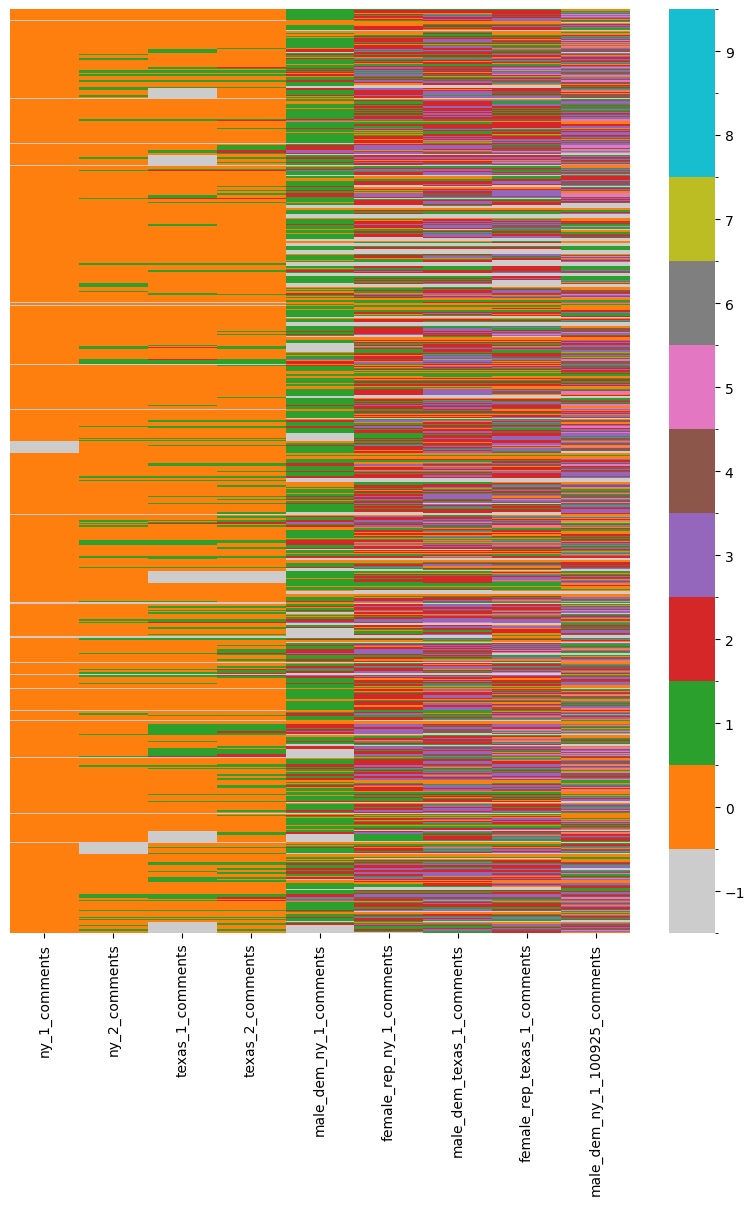

In [147]:
col1 = 'ny_1_comments'
col2 = 'ny_2_comments'
col3 = 'texas_1_comments'
col4 = 'texas_2_comments'
col5 = 'male_dem_ny_1_comments'
col6 = 'female_rep_ny_1_comments'
col7 = 'male_dem_texas_1_comments'
col8 = 'female_rep_texas_1_comments' 
col9 = 'male_dem_ny_1_100925_comments'

base_cmap = plt.cm.tab10(np.linspace(0.1, 1, 10))  # colors for 0–9
colors = np.vstack(([0.8, 0.8, 0.8, 1.0], base_cmap))  # first color for -1
cmap = ListedColormap(colors)

values = np.arange(-1, 10)
bounds = np.arange(-1.5, 10.5, 1)
norm = BoundaryNorm(bounds, cmap.N)

codes = []

for x in zip(merged_df[col1], merged_df[col2], merged_df[col3],
             merged_df[col4], merged_df[col5], merged_df[col6],
             merged_df[col7], merged_df[col8], merged_df[col9]):

    present_already = []
    temp_code = []
    for a in x:
        if pd.isna(a):
            c = -1
        else:
            if a not in present_already:
                c = len(present_already)
                present_already.append(a)
            else:
                c = present_already.index(a)
        temp_code.append(c)

    codes.append(tuple(temp_code))

    # c1, c2 = 0, 0
    # if pd.isna(x):
    #     c1 = -1
    # if pd.isna(y):
    #     c2 = -1

    # if pd.notna(x) and pd.notna(y):
    #     if x == y:
    #         c1, c2 = 0, 0
    #     else:
    #         c1, c2 = 0, 1

    # codes.append((c1, c2))


fig, ax = plt.subplots(figsize=(10, 12))
ax = sns.heatmap(
    codes,
    annot=False,
    vmin=-1, vmax=11,
    cbar_kws={"ticks": range(-1, 11)},
    linewidths=0,
    linecolor=None,
    yticklabels=False,
    xticklabels=[col1, col2, col3, col4, col5, col6, col7, col8, col9],
    cmap=cmap,
    norm=norm,
    ax=ax
)

# indices = merged_df["file_name"].drop_duplicates().index
# for y in indices:
#     ax.hlines(
#         y, *ax.get_xlim(), 
#         linestyles="dotted",
#         linewidth=1,
#         color="black",
#     )

plt.show()


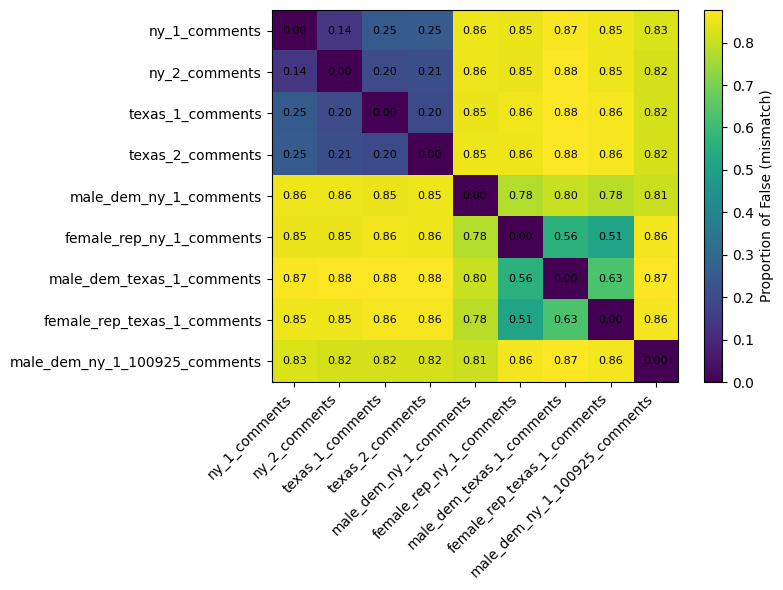

In [173]:
cols = [col1, col2, col3, col4, col5, col6, col7, col8, col9]

false_ratio = pd.DataFrame(index=cols, columns=cols, dtype=float)

for c1 in cols:
    for c2 in cols:
        if c1 == c2:
            false_ratio.loc[c1, c2] = 0.0
        else:
            comp = merged_df[c1] == merged_df[c2]
            false_ratio.loc[c1, c2] = (~comp).mean()
            false_ratio.loc[c2, c1] = false_ratio.loc[c1, c2]


fig, ax = plt.subplots(figsize=(8, 6))

im = ax.imshow(false_ratio.values, aspect='auto')

ax.set_xticks(range(len(cols)))
ax.set_yticks(range(len(cols)))
ax.set_xticklabels(cols, rotation=45, ha='right')
ax.set_yticklabels(cols)

for i in range(len(cols)):
    for j in range(len(cols)):
        ax.text(j, i, f"{false_ratio.iloc[i, j]:.2f}",
                ha='center', va='center', fontsize=8)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Proportion of False (mismatch)')

plt.tight_layout()
plt.show()


In [ ]:
cols = [col1, col2, col3, col4, col5, col6, col7, col8, col9]
unique_files = merged_df['file_name'].unique().tolist()

for file in unique_files:
    diffs_df = pd.DataFrame(index=cols, columns=cols, dtype=float)
    unique_comments = {}

    for col in cols:
        unique_comments[col] = merged_df[merged_df['file_name'] == file][col].dropna().unique().tolist()

    
    for c1 in cols:
        for c2 in cols:
            if c1 != c2:
                diff = set(unique_comments[c1]).symmetric_difference(set(unique_comments[c2]))
                try:
                    prop = len(diff) / min(len(unique_comments[c1]), len(unique_comments[c2]))
                except ZeroDivisionError:
                    prop = None
            else:
                prop = 0.0
            diffs_df.loc[c1, c2] = prop

    fig, ax = plt.subplots(figsize=(8, 6))

    im = ax.imshow(diffs_df.values, aspect='auto')

    ax.set_xticks(range(len(cols)))
    ax.set_yticks(range(len(cols)))
    ax.set_xticklabels(cols, rotation=45, ha='right')
    ax.set_yticklabels(cols)

    for i in range(len(cols)):
        for j in range(len(cols)):
            ax.text(j, i, f"{diffs_df.iloc[i, j]:.2f}",
                    ha='center', va='center', fontsize=8)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Proportion of False (mismatch)')

    plt.tight_layout()
    plt.show()



# Observations:

Baselines dont differ much (ny vs ny or ny vs texas)
Diff between baseline and dem/rep crawls is observed.

# Next to do:

stick to Ny1, texas 2.
Develop methods to compare any 2.
Then collect more data